# ATOM

Authors : Rémi Morvan & Philippe Mathieu (CRISTAL/SMAC, université de Lille)

Date : 2018

ATOM is an order-driven financial market model into which artificial trading agents can interact. In particular, it allows to see the consequences of order executions, to test trader behaviours or to test market regulation rules. ATOM can manage thousands of agents simultaneously on a multi-option market with a double order book such as Euronext-NYSE.

# Getting to know Atom

In [1]:
from atom import *
from data_processing import *
import numpy as np
import random
import statsmodels.tsa.stattools as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## Tutorial

To create a market, simply do `Market(assets)`, where `assets` is the list of assets in the market. Basically, there are two types of agents:
* Dumb agents, which don't send out any orders except the ones they are asked to send out.
* ZITs, which send, each time they have the chance,  a random order,  the price of which is uniformly drawn between 1000 and 9999 and the quantity between 1 and 9.

To create these agents, the market must be passed to them as a parameter. The `add_trader` method of the market is used to add the agents to the market.

### Dumb Agents

A dumb agent is just an intermediary between us and the market, allowing us to send the order we want. To do this, we use the agent's `send_order` method, which takes an order and the market as parameters.

The first type of order is limit orders, which are created with the `LimitOrder(asset, source, direction, price, qty)` command.

In [2]:
m = Market(['Apple', 'Google']) # Creat, in which the tradable assets are 'Apple' and 'Google'
t = DumbAgent(m, name='pauline') # Create a dumb agent
m.add_trader(t) # Add the dumb agent to the market

t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
# The dumb agent sent the market an order to sell 10 shares of Apple stock at $5,000.
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
# The dumb agent sent the market an order to buy 5 shares of Apple stock at 6,000.

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;pauline;0;Apple:0,Google:0
AgentWealth;pauline;0;905216
LimitOrder;Apple;pauline;ASK;5000;10;1070848
LimitOrder;Apple;pauline;BID;6000;5;1244160
Price;Apple;pauline;pauline;5000;5;1393152
Agent;pauline;0;Apple;0;1431040
AgentWealth;pauline;0;1462272


### Trace

Atom can provide a trace of all operations performed during execution. This makes it possible to see precisely which operations are performed by the agents and the consequences of these different operations. The first lines (starting with '#') of this trace specify the syntax used.
* The LimitOrder and CancelMyOrders lines are displayed when an order (LimitOrder or CancelMyOrders) has been sent.
* Tick lines represent the end of a tick 
* Price lines are displayed when a price is fixed (long fixing)
* NewAgent lines are displayed when an agent is added to the market
* The Agent lines are displayed when an agent has its cash or quantity of shares modified
* AgentWealth lines correspond to the agents wealth

This trace can be directed to different outputs (screen, file, no trace) using the parameter `out` , when the market is created:
* If nothing is specified, the trace is displayed in the console.
* If `out = None`, nothing is displayed
* If `out = FileObject`, the trace is displayed in a file. If you use this method, it is imperative to remember to close the file after you finish writing to it.

In [3]:
file = open('trace.dat', 'w') # We open the file trace.dat for writing

m = Market(['Apple'], out=file) # We give this file to the market
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)

file.close()  # Do not forget to close the file

A `print_state()` method, provided by market, displays the number of orders received, the number of prices set, and the number of pending ASK and BID orders.

In [4]:
m = Market(['Apple'])
t = DumbAgent(m, name='paul')
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;paul;0;Apple:0
AgentWealth;paul;0;561408
LimitOrder;Apple;paul;ASK;5000;10;641536
LimitOrder;Apple;paul;BID;6000;5;730112
Price;Apple;paul;paul;5000;5;795136
Agent;paul;0;Apple;0;813824
AgentWealth;paul;0;831232
# Nb orders received: 2
# Nb fixed prices: 1
# Leaving ask size: 1
# Leaving bid size: 0


### ZITs

ZITs can be created in the same way as dumb agents, using the `ZITTrader(m)` command. Once ZITs have been created and added to the market, one can use the `run_once()` market method, which gives each agent a chance to place an order on each asset.

In [5]:
m = Market(['Apple'])
m.add_trader(ZITTrader(m))
m.add_trader(ZITTrader(m))
m.run_once()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 4;0;Apple:0
AgentWealth;ZIT 4;0;872960
NewAgent;ZIT 5;0;Apple:0
AgentWealth;ZIT 5;0;1216256
LimitOrder;Apple;ZIT 5;ASK;8100;6;1364224
LimitOrder;Apple;ZIT 4;BID;3755;6;1415424
Tick;1;1446144


You can also use the `generate(nb_ZIT, nb_turn)` map method, which creates nb ZITS, adds them to the market and does nb_turn laps. The previous code is therefore equivalent to the following code :

In [6]:
m = Market(['Apple'])
m.generate(2, 1)

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 6;0;Apple:0
AgentWealth;ZIT 6;0;303104
NewAgent;ZIT 7;0;Apple:0
AgentWealth;ZIT 7;0;352768
LimitOrder;Apple;ZIT 6;ASK;3267;3;403712
LimitOrder;Apple;ZIT 7;ASK;6385;5;446720
Tick;1;476416


### To go further...

Finally, all agents have two optional parameters:
* ``initial_assets``, which is a list of the same size as the market assets list, and contains all the assets the agents have. If nothing is specified, it is assumed to be a list filled with zeros.
* ``cash``, which is the initial cash available to the agent and is 0 if nothing is specified.

For example, if `m = Market(['Apple', 'Google'])`, then the command `m.add_trader(ZITTrader(m, [5, 10], 5000))` adds to the market a ZIT that initially has 5000 cash, 5 shares of Apple and 10 shares of Google.

The `generate` method has two parameters `init_assets` and `init_cash`, which are both integers. Each ZIT is then created with an initial cash value equal to `init_cash' and with `init_assets' actions for each asset.

In addition, the market has an optional `fix' parameter, which defaults to `'L'` (long fixing), and can also be set to `'S'` (short fixing).

Finally, the market can be given a `trace' parameter, which can be set to the following values:
* `'all'': all information is written to the trace, even order books.
* ``all except orderbooks`` (default): like `all`, but orderbooks are not written
* a sub-list of `['order', 'tick', 'price', 'agent', 'new agent', 'wealth', 'orderbook']`: the values in this sub-list correspond to the types of information we want to see written in the trace.

For example, if `trace=['price', 'wealth']`, then only the lines "Price" and "AgentWealth" will be written.

In [7]:
m = Market(['Apple', 'Google'], trace='all')
m.generate(2, 3, 10, 10000)
m.print_state()
# Created two ZITs, which will take part in three rounds of speech
# and who initially have 10,000 in cash, 10 Apple shares and 10 Google shares...

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 8;10000;Apple:10,Google:10
AgentWealth;ZIT 8;110000;38003200
NewAgent;ZIT 9;10000;Apple:10,Google:10
AgentWealth;ZIT 9;110000;38026240
LimitOrder;Apple;ZIT 9;ASK;2225;8;38052352
OrderBook Apple:
Asks:
	LimitOrder;Apple;ZIT 9;ASK;2225;8;38052352
Bids:
	Empty
LimitOrder;Google;ZIT 9;ASK;1155;5;38085888
OrderBook Google:
Asks:
	LimitOrder;Google;ZIT 9;ASK;1155;5;38085888
Bids:
	Empty
LimitOrder;Apple;ZIT 8;BID;7786;4;38110464
OrderBook Apple:
Asks:
	LimitOrder;Apple;ZIT 9;ASK;2225;8;38052352
Bids:
	LimitOrder;Apple;ZIT 8;BID;7786;4;38110464
Price;Apple;ZIT 8;ZIT 9;2225;4;38155264
Agent;ZIT 9;18900;Apple;6;38163712
Agent;ZIT 8;1100;Apple;14;38170624
AgentWealth;ZIT 9;82250;38188288
AgentWealth;ZIT

Orderbooks are displayed each time they are modified.

## Using the trace to display different curves

In [8]:
file = open('trace.dat', 'w')

m = Market(['Apple', 'Google'], out=file)
m.generate(3, 100, 10, 0)
m.print_state()

file.close()

### Price display

Prices can be extracted from the trace using the `extract_prices' function, which takes a filename as input, and returns a dictionary whose keys are assets and values are tuples (T, P), with T the list of timestamps and P the list of corresponding prices (for a given asset).

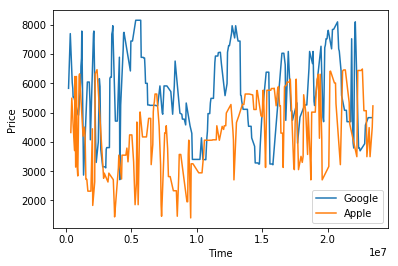

In [9]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

### Displaying the evolution of agents wealth

At the end of a simulation, the wealth of an agent can be accessed with the `get_wealth' method (which takes the market as a parameter). For example, we can display the characteristics (with the `get_infos` method) of the richest and the poorest agent:

In [10]:
t_max = m.traders[0]
t_min = m.traders[0]
for t in m.traders: # We go through all the traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t
    elif t.get_wealth(m) < t_max.get_wealth(m):
        t_min = t
print("Richest agent - "+t_max.get_infos(m))
print("Poorest agent - "+t_min.get_infos(m))

Agent le plus riche - ZIT 11:
Cash: -207610
Apple: 62
Google: 6
Wealth: 145420

Agent le plus pauvre - ZIT 10:
Cash: 194431
Apple: -17
Google: -16
Wealth: 28356



It is of course possible to display the evolution of the wealth of all the agents, by reading the trace: the function `extract_wealths` takes a filename as input and returns a dictionary whose keys are the agents and whose values are lists (T, W) where T is the list of timestamps and W the list of the wealths of that agent.

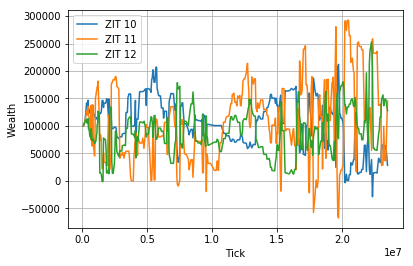

In [11]:
Wealth = extract_wealths('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

It is also possible with `extract_cash` to retrieve a dictionary of the same structure for each Agent cash.

### Displaying the returns

One can of course display the sequence of returns using numpy: if $p_n$ is the $n$-th element of Prices, then
> (Prices[1:]-Prices[:-1])/Prices[:-1] (resp. np.log(Prices[1:]) - np.log(Prices[:-1]))

gives the sequence of $\dfrac{p_{n+1}-p_n}{p_n}$ (resp. $\ln(p_{n+1})-\ln(p_n)$).



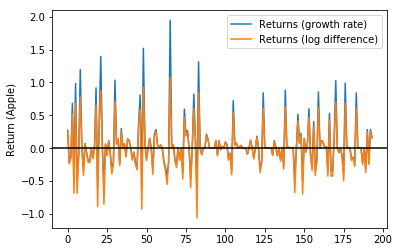

In [12]:
asset = 'Apple'
Prices = np.array(extract_prices('trace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

The histogram of the returns (defined as the logarithmic difference) can be displayed. To do this, we have a function `process_returns_hist`, which takes as inputs the name of the file in which the trace is stored, the name of the asset for which we are going to calculate the returns, and a number of points. In return, we obtain a tuple (R, D, N) where R is a list of returns, D is the list of their densities, and N is the density of the normal distribution of the same expectation and standard deviation.

In [13]:
# New market generation
# It's better to have a lot of points, even if it's a bit long to calculate
file = open('trace.dat', 'w')
asset = 'Apple'
m = Market([asset], out=file, trace=['price'])
# We only write the prices in the trace, those are the only lines we need #
# And it saves a little bit of computing time
m.generate(10, 10000)
file.close()

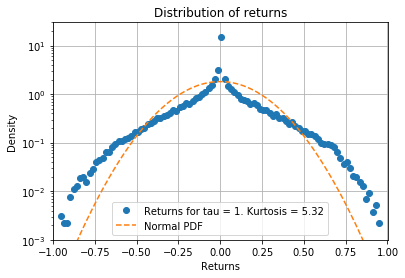

In [14]:
draw_returns_hist('trace.dat', asset, 100)

The stylized fact associated with profitability is well observed: compared to a Gaussian of the same expectation and standard deviation, there is a strong kurtosis (central peak of greater amplitude) and thicker tails.

Note: Why choose the logarithmic difference rather than the rate of increase?
Because the logarithmic difference has a nice property: if we go from a $p$ price to a $p'$ price, then the profitability will be $r_1 = \log(p') - \log(p)$; if we go from $p'$ to $p$, we have a profitability of $r_2 = log(p) - log(p') = -r_1$. This property is not verified by the rate of increase: if we limit ourselves to prices drawn between 1000 and 10000, the maximum rate of increase is 9, and the minimum rate of increase is $-0.9$. The distribution of returns defined as the rate of increase will therefore not be symmetrical.

Note 2: This distinction is important because working with ZIT means that prices can be subject to sudden large variations. In a real market, these variations are small, so if we go from a $p$ price to a $p'$ price, we have $\Delta(p) = |p'-p| << p$, so: $log(p') - log(p) = \log\left(1+\dfrac{p'-p}{p}\right) \sim \dfrac{p'-p}{p}$. So, in a real market, no matter which definition you choose, you'll get roughly the same result.

### Histogram of profitability when prices are set at random

The purpose of this section is to show that the stylized fact that one gets with an asynchronous order-book financial market cannot be obtained with randomly set prices.
To illustrate this, we will generate a false trace in which prices (500,000) are randomly fixed uniformly between 1 and 100.

In [15]:
# We create our own random price-fixing trace 
out = open('fake_trace.dat', 'w')
t0 = int(time.time()*1000000)
for i in range(5000000):
    out.write("Price;Apple;Agent 0;Agent 0;%i;1;%i\n" % (random.randint(1000, 9999), int(time.time()*1000000)-t0))
out.close()

We will then display the profitability histogram.

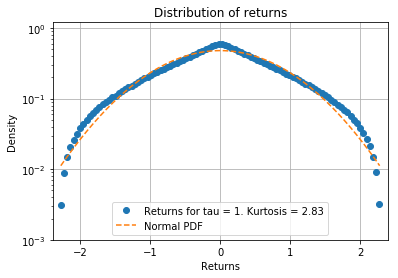

In [16]:
draw_returns_hist('fake_trace.dat', 'Apple', 100)

We no longer see a kind of Gaussian with a large peak and thick tails, but near the centre two half-lines which at the ends have a tail that is not as thick as the Gaussian. The prices set by an order-book system are therefore clearly not of the same structure as a simple random draw, even if the agents themselves only make random choices.

### Displaying the autocorrelation of returns

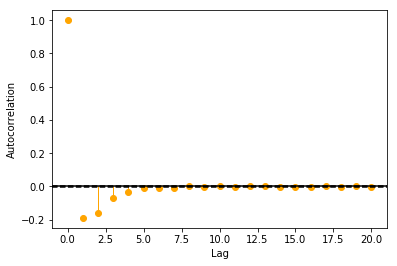

In [17]:
Prices = np.array(extract_prices('trace.dat')[asset][1])
Returns = np.log(Prices[1:]) - np.log(Prices[:-1])
acf = stats.acf(Returns, nlags=20,fft=False)
plt.plot(range(21), acf, 'o', color="orange")
plt.bar([x+0.02 for x in range(21)], acf, .04, color="orange")
plt.axhline(0, color='k')
sigma = max(np.abs(acf[10:]))
plt.axhline(sigma, color='k', linestyle='--')
plt.axhline(-sigma, color='k', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## Use of replay

ATOM can also be used as a flow-replayer, using the `replay' method of the market. The content of this type of file is exactly the same as an ATOM trace file, but Replay only reads agent creations and orders sent (the "NewAgent" and "Order" lines).
It is therefore possible to generate a trace with `generate' and replay the resulting file with `replay'. As we can see, ATOM offers a virtuous circle.

In [18]:
m = Market(['LVMH'], trace=['price'])
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;23;23;45500;10;6363136
Price;LVMH;23;23;45800;10;6424320
Price;LVMH;23;23;45800;7;6452224
Price;LVMH;23;23;45500;3;6471168
Price;LVMH;23;23;42000;2;6487296
Price;LVMH;23;23;42000;12;6504192
Price;LVMH;23;23;34000;18;6557184
Price;LVMH;23;23;34000;11;6577408
Price;LVMH;23;23;34000;5;6593024
# Nb orders received: 11
# Nb fixed prices: 9
# Leaving ask size: 0
# Leaving bid size: 0


We'll see what happens if we choose the short fixing.

In [19]:
m = Market(['LVMH'], trace=['price'], fix='S')
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;24;24;45500;10;616960
Price;LVMH;24;24;45800;10;660480
Price;LVMH;24;24;42000;2;704512
Price;LVMH;24;24;42000;12;723968
Price;LVMH;24;24;34000;18;749824
Price;LVMH;24;24;34000;11;771072
Price;LVMH;24;24;34000;5;788480
# Nb orders received: 11
# Nb fixed prices: 7
# Leaving ask size: 0
# Leaving bid size: 0


With the short fixing, we see that 7 prices are fixed, compared to 9 for the long fixing.

### Virtuous circle

We'll generate a trace with `generate', then play back the trace. We should observe that the final state of the system is identical in both cases. To make sure that `replay' does not cheat, we will only display the NewAgent and LimitOrder lines in the trace.

In [20]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file, trace=['newagent', 'order'])
m.generate(2, 1000, init_assets=10, init_cash=100000)
file.close()

for t in m.traders:
    print(t.get_infos(m))

ZIT 25:
Cash: 569395
Apple: -54
Google: 135
Microsoft: -181
Wealth: 235594

ZIT 26:
Cash: -369395
Apple: 74
Google: -115
Microsoft: 201
Wealth: 331526



In [21]:
m2 = Market(['Apple', 'Google', 'Microsoft'], out=None)
m2.replay('trace.dat')

for t in m2.traders:
    print(t.get_infos(m2))

27:
Cash: 569395
Apple: -54
Google: 135
Microsoft: -181
Wealth: 235594

28:
Cash: -369395
Apple: 74
Google: -115
Microsoft: 201
Wealth: 331526



That's what we're looking at! (Our agents just have different names.)

## Exercises

### Market generation

**1. Generate a `mytrace.dat` file with 1 order book and 3 ZITs with initially 10 actions and 1000 cash, running for 100 rounds**.

In [22]:
# Answer

file = open('mytrace.dat', 'w')

m = Market(['Apple'], out=file)
m.generate(3, 200, 10, 1000)
m.print_state()

file.close()


**2. Display the evolution of the share price**.

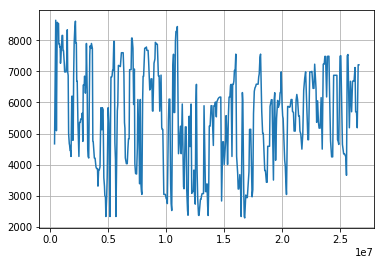

In [23]:
# Answer

prices = extract_prices('mytrace.dat')
plt.plot(prices["Apple"][0],prices["Apple"][1])
plt.grid()
plt.show()

**3. Display the histogram of the evolution of the quantities of shares traded with the function `extract_qties`**.

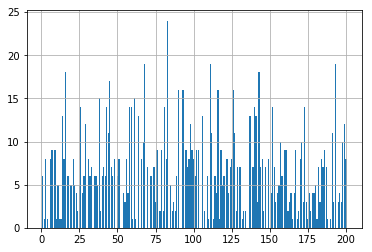

In [24]:
# Answer

qties = extract_qties('mytrace.dat')
plt.bar(qties[0],qties[1])
plt.grid()
plt.show()

**4. Display the evolution of the wealth and cash (`extract_cash`) of the richest agent at the end (the name of a trader t can be obtained from his id: t.trader_id)**

Agent le plus riche - ZIT 31:
Cash: -650053
Apple: 137
Wealth: 337854



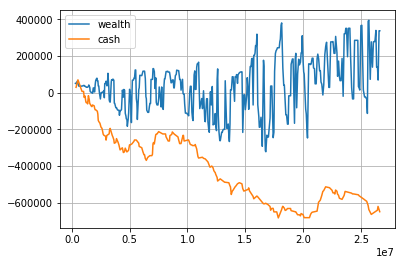

In [25]:
# Answer

t_max = m.traders[0]
for t in m.traders: # We go through all the traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t

print("Richest agent - "+t_max.get_infos(m))
name = "ZIT "+str(t_max.trader_id)
Wealth = extract_wealths('mytrace.dat')
Cash = extract_cash('mytrace.dat')
plt.plot(Wealth[name][0],Wealth[name][1],label="wealth")
plt.plot(Cash[name][0],Cash[name][1],label="cash")
plt.legend(loc='best')
plt.grid()
plt.show()
